In [1]:
import numpy as np
import pandas as pd
import requests
import networkx as nx
import random
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sns

In [2]:
url = "https://crowding.data.tfl.gov.uk/NUMBAT/NUMBAT%202023/NBT23FRI_outputs.xlsx"

r = requests.get(url)
with open("NBT23FRI_outputs.xlsx", "wb") as f:
    f.write(r.content)

xls = pd.ExcelFile("NBT23FRI_outputs.xlsx")
print(xls.sheet_names)

['_Cover', 'Link_Loads', 'Link_Frequencies', 'Line_Boarders', 'Station_Flows', 'Station_Entries', 'Station_Exits', 'Station_Boarders', 'Station_Alighters']


## Monte Carlo-Based Route Simulation

To capture realistic patterns of passenger movement within the transport network, we implemented a Monte Carlo simulation pipeline. A directed graph was first constructed from station-to-station flow data, with each edge weighted by total passenger volume. Transfer behavior at interchange stations was modeled probabilistically, allowing random transitions between lines based on a predefined switching probability.

In our simulation, transfer behavior at interchange stations was modeled using a fixed 30% probability, representing a moderate level of assumed switching. While not derived from a specific empirical study, this value reflects conventions commonly adopted in agent-based transport simulations where detailed behavioral data is unavailable (Zheng et al., 2013). Transitions along transit links were weighted by observed station-to-station passenger volumes, ensuring that, despite the assumed transfer heuristic, route choices remain largely governed by observed flow patterns.

To prevent overly complex or unrealistic passenger paths, each simulated journey was capped at five steps (i.e., up to five transfers). This aligns with empirical findings from TfL and other urban transit studies, which suggest that most passengers make fewer than 3-5 transfers per trip (Zhong et al., 2014; Nagel et al., 2007).

We conducted 30,000 simulations, using a fixed random seed to ensure reproducibility. Each simulated route began at a station selected in proportion to its observed entry volume, and proceeded step by step, with each subsequent station drawn from a weighted distribution informed by observed link flows and the 30% transfer probability. This stochastic framework captures both dominant travel behaviors and realistic variation in passenger routing.

After the simulation, we extracted all origin-destination (OD) pairs and computed their occurrence frequencies. To focus on consistently recurring travel patterns, we retained only those OD pairs that appeared 15 times or more across the 30,000 simulations. This threshold was chosen based on the highly skewed frequency distribution of OD pairs, allowing us to exclude extremely rare, potentially random routes and concentrate the analysis on statistically meaningful patterns.

_References:_  
_Zheng, H., Son, Y.-J., Chiu, Y.-C., Head, L., Feng, Y., Xi, H., Kim, S., & Hickman, M. (2013). A Primer for Agent-Based Simulation and Modeling in Transportation Applications. U.S. Department of Transportation, Federal Highway Administration, Office of Operations Research and Development. https://trid.trb.org/view/1278955._  
_Zhong, C., Arisona, S. M., Huang, X., Batty, M., & Schmitt, G. (2014). Detecting the dynamics of urban structure through spatial network analysis. International Journal of Geographical Information Science, 28(11), 2178-2199. https://doi.org/10.1080/13658816.2014.914521_  
_Nagel, K., & Marchal, F. (2007). Computational methods for multi-agent simulations of travel behavior. https://www.researchgate.net/publication/239538480_Computational_methods_for_multi-agent_simulations_of_travel_behavior_  

**Note:**  
In the early stage of our analysis, we used the `Link_Load` data to simulate approximately 30,000 complete passenger trajectories through the London Underground. This was intended to reflect realistic travel paths and network usage patterns.

However, as the focus of the project shifted toward origin-destination (OD) pair analysis—particularly to identify high-frequency start-end combinations for accessibility improvement—the simulation results were summarized at the OD level.

While `Station_Flow` provides platform-level detail—including movement types (Board, Alight, Interchange), line directions (e.g., "Piccadilly // WB"), and time periods—it lacks explicit, end-to-end directional pairing between origin and destination stations. Although individual segments can be interpreted manually, reconstructing full journeys requires assumptions across interchanges, as the dataset does not contain sequential trip logic or passenger paths across multiple stations.

For our Monte Carlo simulation, which involved scalable generation of realistic passenger journeys, we required a dataset that naturally supports path-based modeling at the OD level. Therefore, we selected `Link_Loads` as our core data source. Unlike `Station_Flow`, `Link_Loads` directly encodes station-to-station passenger volumes along transit links, providing a clearer structure for constructing a weighted, directed graph of the network.

In [3]:
df_links = pd.read_excel(xls, sheet_name="Link_Loads", header=2)
df_flows = pd.read_excel(xls, sheet_name="Station_Flows", header=2)
df_entries = pd.read_excel(xls, sheet_name="Station_Entries", header=2)
df_exits = pd.read_excel(xls, sheet_name="Station_Exits", header=2)
df_boarders = pd.read_excel(xls, sheet_name="Station_Boarders", header=2)
df_alighters = pd.read_excel(xls, sheet_name="Station_Alighters", header=2)

# Extract a list of interchange station names from flow data
def extract_interchange_stations(df_flows):
    interchange_rows = df_flows[df_flows["Movement"].str.contains("Interchange", na=False)]
    interchange_stations = interchange_rows["To Station"].dropna().unique().tolist()
    return interchange_stations

# # Construct a directed graph where nodes are stations and edges represent flows
# def build_graph_from_links(df_links, entry_stations=None, exit_stations=None):
#     G = nx.DiGraph()
#     for _, r in df_links.iterrows():
#         # Add edge with weight = flow volume
#         G.add_edge(r["From Station"], r["To Station"], weight=r["Total"])
#     # Ensure all entry and exit stations are included in the graph.
#     # This step prevents missing nodes when some stations appear only in df_entries/df_exits
#     # but not in the link-level flow data (df_links). Without this, the graph G may be incomplete, 
#     # leading to simulation errors or missing routes.
#     if len(entry_stations) > 0:
#         for station in entry_stations:
#             if station not in G:
#                 G.add_node(station)
#     if len(exit_stations) > 0:
#         for station in exit_stations:
#             if station not in G:
#                 G.add_node(station)
#     return G

# Construct a directed graph where nodes are stations and edges represent flows
def build_graph_from_links(df_links, entry_stations=None, exit_stations=None):
    G = nx.DiGraph()
    
    from_stations = set()
    to_stations = set()

    for _, r in df_links.iterrows():
        # Add edge with weight = flow volume
        from_stations.add(r["From Station"])
        to_stations.add(r["To Station"])
        G.add_edge(r["From Station"], r["To Station"], weight=r["Total"])

    # Flag suspicious station names not in df_links
    if entry_stations is not None and len(entry_stations) > 0:
        missing_entries = [s for s in entry_stations if s not in from_stations and s not in to_stations]
        if missing_entries:
            print(f"[Warning] Entry stations not found in df_links: {missing_entries}")
    if exit_stations is not None and len(exit_stations) > 0:
        missing_exits = [s for s in exit_stations if s not in from_stations and s not in to_stations]
        if missing_exits:
            print(f"[Warning] Exit stations not found in df_links: {missing_exits}")

    # Still add them to avoid simulation errors (but now at least can know which are missing)
    # Note: To avoid simulation interruptions, we ensured all entry and exit stations are included in the graph 
    # even if not found in the Link_Loads dataset. 
    # However, a warning is printed when mismatched names are detected, 
    # helping us identify possible inconsistencies in station naming (e.g., Camden Town vs Camden Town LU). 
    # These are manually reviewed and corrected where necessary.
    if entry_stations is not None and len(entry_stations) > 0:
        for station in entry_stations:
            if station not in G:
                G.add_node(station)
    if exit_stations is not None and len(exit_stations) > 0:
        for station in exit_stations:
            if station not in G:
                G.add_node(station)

    return G

def build_entry_weights(df_entries):
    entries = df_entries[["Station", "Total"]].dropna()
    return dict(zip(entries["Station"], entries["Total"]))

def build_exit_weights(df_exits):
    exits = df_exits[["Station", "Total"]].dropna()
    return dict(zip(exits["Station"], exits["Total"]))

# Create dictionaries for total boardings and alightings per station
def build_board_alight_dicts(df_boarders, df_alighters):
    board_dict = df_boarders.groupby("Station")["Total"].sum().to_dict()
    alight_dict = df_alighters.groupby("Station")["Total"].sum().to_dict()
    return board_dict, alight_dict

# Simulate a single route starting from a given station
# Incorporates random transfers at interchange stations and weighted moves based on flow

# max_transfers controls the maximum number of inter-line transfers in a simulated route.
# A value of 5 reflects typical commuter behavior, where most metro users make fewer than 3-5 transfers per journey.
# This cap avoids overly complex routes while preserving realistic trip patterns and ensuring computational efficiency.

# transfer_prob: assumed probability that a passenger will transfer at an interchange station (30%).
# This is consistent with agent-based modeling practices where detailed behavioral data is unavailable,
# and was referenced from heuristics in Zheng et al. (2013).
def simulate_route(G, start, interchange_list, board_dict, alight_dict,
                   max_transfers=5, transfer_prob=0.3):

    path = [start]
    cur = start
    score = 0
    transfer_count = 0 # New: transfer count to limit transfers

    while transfer_count < max_transfers:
        # Possibly transfer at interchange stations based on probability
        if cur in interchange_list and random.random() < transfer_prob:
            candidates = [s for s in G.successors(cur) if s in interchange_list and s not in path]
            if candidates:
                # Transfers at interchange stations are chosen uniformly at random among possible successors.
                # This reflects the lack of detailed transfer preference data.
                nxt = random.choice(candidates)
                path.append(f"[TRANSFER→]{nxt}")
                cur = nxt
                transfer_count += 1 
                continue

        if cur not in G:
            break
        # If no transfer occurs, choose among all successor stations not yet visited.
        # Interchange stations are not excluded here to allow for indirect transfers or returns.
        succ = [s for s in G.successors(cur) if s not in path]
        if not succ:
            break
        # Choose next station based on link weights (passenger volume)
        weights = [G[cur][s]["weight"] for s in succ]
        # If all weights are zero or if no successors remain, break the loop.
        # This ensures robustness against missing data or isolated nodes.
        if sum(weights) == 0 or len(weights) != len(succ):
            break
        cur = random.choices(succ, weights=weights, k=1)[0]
        path.append(cur)
        # Accumulate a score representing passenger flow intensity at each visited station.
        # The score is calculated as the sum of boardings and alightings; default = 0 ensures robustness for stations with missing data.
        # This metric can be used to evaluate how "popular" or realistic a simulated route is, supporting downstream analysis or prioritization.
        score += board_dict.get(cur, 0) + alight_dict.get(cur, 0)
    return path, score

# Run multiple route simulations and collect results
def run_simulation_pipeline(df_links, df_flows, df_entries, df_exits, df_boarders, df_alighters,
                            num_routes=10000):
    
    interchange_stations = extract_interchange_stations(df_flows)
    entry_stations = df_entries["Station"].dropna().unique()
    exit_stations = df_exits["Station"].dropna().unique()
    start_stations = df_entries.sort_values(by="Total", ascending=False)["Station"].tolist()
    end_stations = df_exits.sort_values(by="Total", ascending=False)["Station"].tolist()
    G = build_graph_from_links(df_links, entry_stations, exit_stations)
    entry_weights = build_entry_weights(df_entries)
    exit_weights = build_exit_weights(df_exits)
    board_dict, alight_dict = build_board_alight_dicts(df_boarders, df_alighters)

    starts = list(entry_weights.keys())
    raw_weights = np.array([entry_weights[s] for s in starts])

    # Convert raw weights to log scale to reduce skewness and improve numerical stability
    log_weights = np.log1p(raw_weights)
    entry_weights = dict(zip(starts, log_weights))
    weights = list(entry_weights.values())

    routes = []
    scores = []
    ends = []

    for _ in range(num_routes):
        start = random.choices(starts, weights=weights, k=1)[0]
        path, score = simulate_route(G, start, interchange_stations, board_dict, alight_dict)
        routes.append(path)
        scores.append(score)
        # Remove transfer tags to get clean end station
        clean_path = [step for step in path if not str(step).startswith("[TRANSFER")]
        end = clean_path[-1] if len(clean_path) >= 2 else None
        ends.append(end)

    df_result = pd.DataFrame({
        "Route": routes,
        "Score": scores,
        "End": ends
    })

    df_result["End Exit Volume"] = df_result["End"].map(exit_weights)

    df_result["Start"] = df_result["Route"].apply(lambda x: x[0] if len(x) > 0 else None)
    df_result = df_result[df_result["Start"].isin(start_stations) & df_result["End"].isin(end_stations)]

    return df_result

def plot_route_pair_frequencies(df_result):
    # Although the initial design aimed at visualizing top simulated routes on a network map (which required a string-based "Route_Pair"), 
    # the project focus was later refined toward OD-pair-based analysis and accessibility optimization. 
    # Nevertheless, the "Route_Pair" representation remains useful for summarizing and ranking simulated OD pairs by frequency,
    # which supports our selection of key pairs for further optimization comparison.
    # Create a combined Start-End key for each route
    df_result["Route_Pair"] = df_result["Start"] + " → " + df_result["End"]

    # Count frequency of each unique Start-End pair
    pair_counts = df_result["Route_Pair"].value_counts().reset_index()
    pair_counts.columns = ["Route_Pair", "Count"]

    # Sort by frequency descending
    pair_counts = pair_counts.sort_values(by="Count", ascending=False).reset_index(drop=True)

    # Plot the frequencies as a line chart
    plt.figure(figsize=(14, 6))
    plt.plot(range(len(pair_counts)), pair_counts["Count"], marker='o', linewidth=1.5)
    plt.title("Frequency of Simulated Start-End Route Pairs", fontsize=14)
    plt.xlabel("Route Pair Rank (sorted by frequency)", fontsize=12)
    plt.ylabel("Number of Simulated Occurrences", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

**Note:**  

In this simulation, we did not explicitly constrain the route to end at a known exit station. Instead, we capped the number of inter-line transfers to five, reflecting common travel patterns observed in large-scale transport studies (Zhong et al., 2014; Nagel et al., 2007). This cap allows journeys to continue through many stations as long as the number of transfers remains within realistic limits, avoiding overly complex or unlikely paths.

The final station in each simulated path does not represent a literal exit, but a plausible stopping point after a realistic sequence of transfers. This abstraction aligns with our goal of identifying high-likelihood route segments, rather than precisely modeling exit behavior.

As the primary aim of this simulation is to uncover typical routing patterns between entry points and potential destinations, rather than exact OD pairs, this approximation is considered suitable for OD-based accessibility analysis.

Moreover, the station exit dataset reflects "typical day" flows with major disruptions and anomalies removed. While this improves consistency, it may under-represent less frequent patterns—such as low-traffic or off-peak exits. Enforcing termination at these stations could introduce bias or exclude valid journeys. To mitigate this, we allow routes to end organically after a capped number of transfers, using `max_transfers` as a practical constraint.

To capture the variability and distribution of possible travel routes in a realistic manner, we employed a Monte Carlo simulation approach. A total of 30,000 simulation runs were conducted. This number was selected as a balance between computational efficiency and statistical robustness.
  
According to the law of large numbers and the central limit theorem, the accuracy of Monte Carlo estimates improves at a rate of O(1/N^(1/2)), where N is the number of samples. In practical terms, increasing the number of runs from 10,000 to 30,000 reduces the expected standard error by approximately 42%, which significantly improves the stability of the estimated route frequency distribution without incurring excessive computational cost.
  
Furthermore, as discussed in Glasserman (2003) and Rubinstein & Kroese (2016), simulation sizes in the range of 10,000 to 100,000 are typically sufficient for modeling aggregate behaviors in large-scale stochastic systems, such as transportation networks. Therefore, we consider 30,000 simulations appropriate for capturing the dominant patterns in route choices and interchange behaviors within our data-driven model.
  
_References:_  
_Glasserman, P. (2003). Monte Carlo Methods in Financial Engineering. Springer_  
_Rubinstein, R. Y., & Kroese, D. P. (2016). Simulation and the Monte Carlo Method (3rd ed.). Wiley_

In [4]:
random.seed(2025)  # Set seed for reproducibility

df_result = run_simulation_pipeline(
    df_links, df_flows, df_entries, df_exits,
    df_boarders, df_alighters,
    num_routes = 30000
    )

display(df_result.head(20))

[Warning] Entry stations not found in df_links: ['Camden Town', 'Kennington']
[Warning] Exit stations not found in df_links: ['Camden Town', 'Kennington']


,Route,Score,End,End Exit Volume,Start
0,"[Marylebone LU, Edgware Road (Bak), [TRANSFER→...",1.915161e+06,Stockwell,11418.710499,Marylebone LU
1,"[Burnt Oak, Edgware]",1.334343e+04,Edgware,6604.488171,Burnt Oak
2,"[Wimbledon Park, Southfields, East Putney, Put...",1.730589e+06,King's Cross St. Pancras,122827.765441,Wimbledon Park
3,"[Langdon Park, Devons Road, Bow Church, Puddin...",7.089259e+05,Canary Wharf EL,23414.970073,Langdon Park
4,"[Westferry, Limehouse DLR, Shadwell DLR, Bank ...",1.531277e+06,Angel,21339.307030,Westferry
5,"[Shenfield, Brentwood, Harold Wood, Gidea Park...",1.039973e+06,Barking,25951.668285,Shenfield
6,"[Bushey, Carpenders Park, Hatch End, Headstone...",9.021720e+04,Harlesden,4415.004122,Bushey
7,"[London Bridge LU, Bank and Monument, Liverpoo...",2.506706e+06,Hammersmith (DIS),30293.731838,London Bridge LU
8,"[Barking Riverside, Barking, Upney, Becontree,...",1.944881e+06,Oxford Circus,88888.967042,Barking Riverside
9,"[West Croydon NR, Norwood Junction, [TRANSFER→...",1.590035e+04,Sydenham,4847.996232,West Croydon NR


d:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
d:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


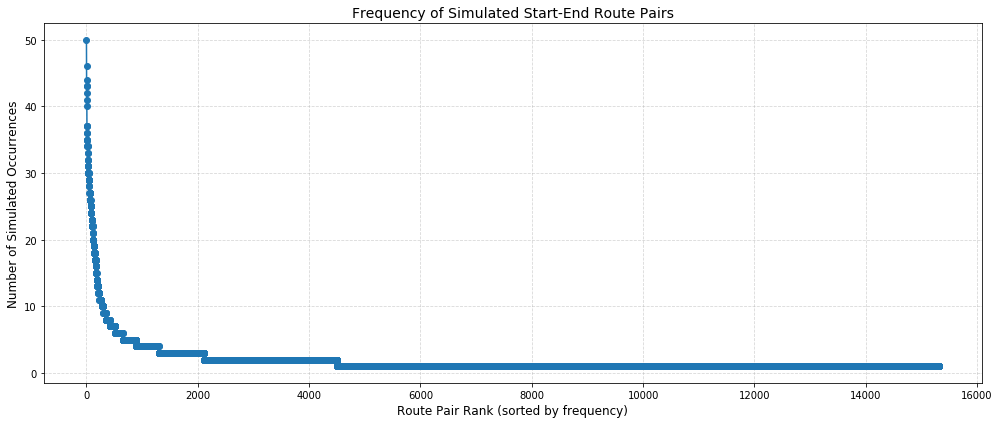

In [5]:
plot_route_pair_frequencies(df_result)

In order to identify the most representative and frequently used travel patterns from the Monte Carlo simulation, we define a route pair (start-end) as a popular route if it appears 15 times or more among the 30,000 simulated journeys. This threshold is based on the observation that while only a small number of start-end route pairs occurred repeatedly, the majority appeared just a few times. In other words, the distribution of route frequencies is highly uneven, with a long tail of rare combinations.
  
By selecting a cutoff of 15 occurrences, we strike a balance between statistical significance and data coverage. The selected route pairs are frequent enough to reflect recurring patterns, yet limited in number to allow focused downstream analysis. This approach avoids over-interpreting rare, potentially random combinations and centers the analysis on routes that consistently emerge in simulated travel behavior.

**Note:**  
The default value of min_occurrence = 15 is based on this long-tailed distribution observed across 30,000 simulated journeys. Setting it as a default parameter simplifies repeated function calls while maintaining consistent filtering logic throughout the analysis.

In [6]:
def count_frequent_route_pairs(df_result, min_occurrence = 15):
    df_result["Route_Pair"] = df_result["Start"] + " → " + df_result["End"]
    pair_counts = df_result["Route_Pair"].value_counts()
    frequent_pairs = pair_counts[pair_counts >= min_occurrence]
    print(f"Number of route pairs that occurred ≥ {min_occurrence} times: {len(frequent_pairs)}")
    return frequent_pairs

frequent_pairs = count_frequent_route_pairs(df_result)

Number of route pairs that occurred ≥ 15 times: 182


In [7]:
def save_frequent_route_pairs_split(df_result, min_occurrence = 15, filename = "frequent_routes.csv"):
    df_result["Route_Pair"] = df_result["Start"] + " → " + df_result["End"]
    pair_counts = df_result["Route_Pair"].value_counts()

    frequent_pairs = pair_counts[pair_counts >= min_occurrence].reset_index()
    frequent_pairs.columns = ["Route_Pair", "Count"]
    frequent_pairs[["Start_Station", "End_Station"]] = frequent_pairs["Route_Pair"].str.split(" → ", expand=True)
  
    output_df = frequent_pairs[["Start_Station", "End_Station", "Count"]]
    output_df.to_csv(filename, index=False)
    
    print(f"Saved {len(output_df)} frequent route pairs to '{filename}'")
    return output_df

frequent_routes = save_frequent_route_pairs_split(df_result, filename = "frequent_routes_final_2.0.csv")

Saved 182 frequent route pairs to 'frequent_routes_final_2.0.csv'


**Note:** The dataset `frequent_routes_final_2.0.csv`, containing 182 frequent OD pairs, will be used in the subsequent stage to collect travel time data for both step-free accessible and regular routes.

## Bus Stop Optimization via P-Median Approximation

To identify optimal locations for additional bus stops, we formulated a simplified variant of the P-Median problem, with the objective of minimizing the total weighted walking cost across frequent OD (origin-destination) pairs derived from the simulated dataset. Each OD pair is weighted by its user count, and penalized by its walking time unless covered by one of the selected new facilities (i.e., bus stops).
  
OD pairs with walking times exceeding a minimum threshold were treated as "underserved". For each such pair, if either the origin or destination is selected as a new bus stop, we assume the walking burden is substantially reduced to a nominal value (set to 1 minute). Otherwise, the full walking cost (i.e., walk_time × user count) is retained. The algorithm evaluates all combinations of up to p new stop locations and selects the one that minimizes the total weighted cost.
  
For the purpose of verifying the method's functionality, both the maximum number of new stops (p = 3) and the minimum walking time threshold (walk_time ≥ 16) were selected arbitrarily. These values were not intended to reflect real-world planning assumptions and carry no empirical significance. They will be further calibrated or replaced based on empirical data and literature-informed benchmarks in subsequent analyses.
  
The method relies on an exhaustive combinatorial search and is therefore limited to a small number of candidate facilities. However, it provides an interpretable and data-driven framework for evaluating the potential impact of targeted interventions in improving network accessibility.

In [20]:
def suggest_new_bus_stops_from_od_walk(df_od, max_new_stops = 3, min_walk_threshold = 5):
    """
    Suggest new bus stops based on OD pairs with high walk_time.
    Expects df_od to contain: ['Start_Station', 'End_Station', 'Count', 'walk_time']
    """

    # Step 1: Filter OD pairs with long walk times
    df_long_walks = df_od[df_od["walk_time"] >= min_walk_threshold].copy()
    if df_long_walks.empty:
        print("No OD pairs exceed the minimum walk threshold.")
        return []

    # Step 2: Expand station frequency as potential demand
    candidate_nodes = set(df_long_walks["Start_Station"]).union(set(df_long_walks["End_Station"]))
    print(f"Found {len(df_long_walks)} OD pairs with walk_time ≥ {min_walk_threshold}")
    print(f"Candidate new stop locations: {len(candidate_nodes)} stations")

    # Step 3: Try all combinations of new stop placements (brute-force, only for small-scale)
    candidate_nodes = list(candidate_nodes)
    best_total_cost = float("inf")
    best_combo = None

    for combo in combinations(candidate_nodes, max_new_stops):
        total_cost = 0
        for _, row in df_long_walks.iterrows():
            u, v = row["Start_Station"], row["End_Station"]
            count = row["Count"]
            walk_time = row["walk_time"]

            # If this OD pair's start or end station is covered by a new bus stop,
            # we assume the walking burden is significantly reduced (e.g., to 1 minute).
            # Otherwise, we keep the original walk_time × number of users.
            if u in combo or v in combo:
                total_cost += 1 * count
            else:
                total_cost += walk_time * count

        if total_cost < best_total_cost:
            best_total_cost = total_cost
            best_combo = combo

    print(f"Suggested new bus stop locations (up to {max_new_stops}):")
    print(best_combo)
    print(f"Total weighted walk cost reduced to: {best_total_cost:.2f}")

    return best_combo

**Note:**  
The dataset `frequent_routes_try.csv` was generated as a test set for experiments where walking time was used as the cost metric in the bus stop optimization.  The walking durations were created using randomized values and do not correspond to actual transport conditions.

As we decided not to proceed with the walking-time-based cost function in the final model, this dataset will no longer be provided or updated.  However, we chose to retain the corresponding code in the notebook for the sake of documenting all tested design alternatives in the final report and demonstrating the evolution of our modeling approach.

In [6]:
df_od = pd.read_csv("frequent_routes_try.csv")
entry_stations = df_entries["Station"].dropna().unique()
exit_stations = df_exits["Station"].dropna().unique()
G = build_graph_from_links(df_links, entry_stations, exit_stations)
suggest_new_bus_stops_from_od_walk(df_od, max_new_stops = 3, min_walk_threshold = 16)  # The numerical selection here is only to verify whether this code can run smoothly. Further changes will be made based on actual needs or literature support in the future.

Found 30 OD pairs with walk_time ≥ 16
Candidate new stop locations: 51 stations
Suggested new bus stop locations (up to 3):
("King's Cross St. Pancras", 'Edgware', 'Stockwell')
Total weighted walk cost reduced to: 12681.00


("King's Cross St. Pancras", 'Edgware', 'Stockwell')

We replaced the original walking-time-based cost with the total estimated travel time between each origin-destination pair, allowing for a more comprehensive reflection of real commuting burdens. For OD pairs whose origin or destination is covered by a new stop, the total time is reduced to a nominal value (e.g., 1 minute). All others retain their original total time. The optimization then selects the combination of up to p new stops that minimizes the weighted total commute time across all selected OD pairs.

Since the unified total travel time across OD pairs (rather than walking time alone) better captures user experience, we plan to use Google Maps API to obtain these values for the frequent OD pairs generated from simulation. A generic route-time estimation script is under development and being debugged. In the meantime, arbitrary values were used to test the algorithm pipeline.

In [5]:
def suggest_new_bus_stops_from_od_total(df_od, max_new_stops = 3, min_total_threshold = 15):
    """
    Suggest new bus stops based on OD pairs with high total travel time.
    Expects df_od to contain: ['Start_Station', 'End_Station', 'Count', 'total_time']
    """

    # Step 1: Filter OD pairs with long total travel time
    df_long_travel = df_od[df_od["Modified_time"] >= min_total_threshold].copy()
    if df_long_travel.empty:
        print("No OD pairs exceed the minimum total time threshold.")
        return []

    # Step 2: Identify candidate stations from underserved OD pairs
    candidate_nodes = set(df_long_travel["Start_Station"]).union(set(df_long_travel["End_Station"]))
    print(f"Found {len(df_long_travel)} OD pairs with total_time ≥ {min_total_threshold}")
    print(f"Candidate new stop locations: {len(candidate_nodes)} stations")

    # Step 3: Try all combinations of new stop placements (brute-force for small-scale test)
    candidate_nodes = list(candidate_nodes)
    best_total_cost = float("inf")
    best_combo = None

    for combo in combinations(candidate_nodes, max_new_stops):
        total_cost = 0
        for _, row in df_long_travel.iterrows():
            u, v = row["Start_Station"], row["End_Station"]
            count = row["Count"]
            total_time = row["Modified_time"]

            # If either end is covered by a new stop, we reduce total time to 1 minute
            if u in combo or v in combo:
                total_cost += 1 * count
            else:
                total_cost += total_time * count

        if total_cost < best_total_cost:
            best_total_cost = total_cost
            best_combo = combo

    print(f"Suggested new bus stop locations (up to {max_new_stops}):")
    print(best_combo)
    print(f"Total weighted travel cost reduced to: {best_total_cost:.2f}")

    return best_combo

**Note:**  
The dataset `final_complete_accessible_routes.csv` was generated using the Jupyter Notebook titled `FINAL_wheelchair_accessible__commute_time.ipynb`. This script implemented a web scraping pipeline simulating user interactions on Google Maps, retrieving step-free (wheelchair accessible) total travel times for OD pairs listed in `frequent_routes_final.csv`.

The scraping was necessary because Google Maps API does not support querying wheelchair-accessible options directly. The output of the notebook forms the basis for the final accessibility-based stop optimization.

In [ ]:
df_od = pd.read_csv("final_complete_accessible_routes.csv")
entry_stations = df_entries["Station"].dropna().unique()
exit_stations = df_exits["Station"].dropna().unique()
G = build_graph_from_links(df_links, entry_stations, exit_stations)
suggest_new_bus_stops_from_od_total(df_od, max_new_stops = 3, min_total_threshold = 30)

Found 66 OD pairs with total_time ≥ 30
Candidate new stop locations: 97 stations
Suggested new bus stop locations (up to 3):
('Seven Sisters', 'Wimbledon', 'Stratford')
Total weighted travel cost reduced to: 97355.00


('Seven Sisters', 'Wimbledon', 'Stratford')

### Analysis of Selected Bus Stop Candidates from Travel Time Distributions  

To further investigate why certain stations-Wimbledon, Stratford, and Seven Sisters-were repeatedly selected as optimal candidates for new bus stops in the model, we examined their step-free travel time distributions from both origin and destination perspectives.

#### As Start Stations  

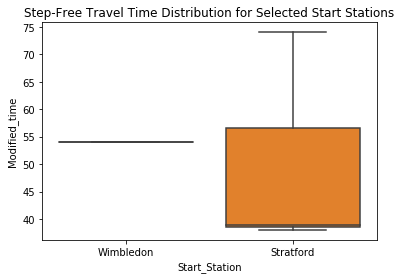

               count       mean        std   min   25%   50%   75%   max
Start_Station                                                           
Stratford        3.0  50.333333  20.502032  38.0  38.5  39.0  56.5  74.0
Wimbledon        1.0  54.000000        NaN  54.0  54.0  54.0  54.0  54.0


In [11]:
sns.boxplot(data=df_od[df_od["Start_Station"].isin(["Wimbledon", "Seven Sisters", "Stratford"])],
            x="Start_Station", y="Modified_time")
plt.title("Step-Free Travel Time Distribution for Selected Start Stations")
plt.show()

df_focus = df_od[df_od["Start_Station"].isin(["Wimbledon", "Seven Sisters", "Stratford"])]
print(df_focus.groupby("Start_Station")["Modified_time"].describe())

Boxplot analysis and descriptive statistics show that:
1. Stratford exhibits a relatively high mean step-free travel time (≈ 50 mins), with noticeable dispersion (std ≈ 20.5).
2. Wimbledon, though based on a single route, also shows a high travel time of 54 mins, suggesting limited accessibility.
3. Seven Sisters did not appear as a start station among high-burden OD pairs, indicating that its accessibility challenge may be more prominent when serving as a destination.

This suggests that Stratford and Wimbledon tend to be inefficient origin points under step-free routing, thus carrying higher weighted costs in the objective function.

#### As End Stations  

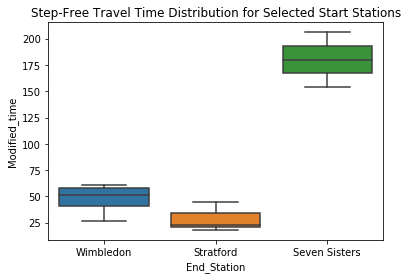

               count        mean        std    min    25%    50%    75%    max
End_Station                                                                   
Seven Sisters    2.0  180.000000  36.769553  154.0  167.0  180.0  193.0  206.0
Stratford        3.0   28.666667  14.364308   18.0   20.5   23.0   34.0   45.0
Wimbledon        4.0   47.500000  15.264338   27.0   40.5   51.0   58.0   61.0


In [ ]:
sns.boxplot(data=df_od[df_od["End_Station"].isin(["Wimbledon", "Seven Sisters", "Stratford"])],
            x="End_Station", y="Modified_time")
plt.title("Step-Free Travel Time Distribution for Selected Start Stations")
plt.show()

df_focus = df_od[df_od["End_Station"].isin(["Wimbledon", "Seven Sisters", "Stratford"])]
print(df_focus.groupby("End_Station")["Modified_time"].describe())

When switching to the destination perspective:
1. Seven Sisters shows exceptionally high step-free travel times, with a mean of 180 mins and a maximum exceeding 200 mins.
2. In contrast, Stratford and Wimbledon exhibit lower values as destination stations, indicating that their accessibility issues are more pronounced when they serve as origins rather than destinations.

This directional imbalance reveals that the burden of step-free travel is not symmetric.  The same station may be a greater bottleneck in one direction (e.g., Seven Sisters as a destination) than in the other.

### Filtering Long-Distance Outliers  

While directional imbalance has revealed stations like Seven Sisters to be disproportionately costly as destinations, further inspection uncovered that a small subset of OD pairs exhibited exceptionally long step-free travel times, in some cases exceeding 200 minutes. These extreme values-though real-risk skewing the optimization process by shifting attention toward a few distant stations at the expense of broader accessibility gains.

To mitigate this, we applied a 95th percentile threshold on total travel time (Modified_time) to trim the top 5% of excessively long OD pairs. This filtering step aimed to:

1. Avoid outlier-driven bias in subsequent stop placement suggestions.
2. Promote a more spatially balanced distribution of candidate locations.
3. Improve model interpretability by focusing on the majority user experience.

#### Statement about 95% Quantile for Travel Time Filtering

The longest 5% of routes (based on total modified travel time) were excluded to reduce the influence of extreme values. This choice is not dictated by a specific threshold in the literature, but follows a common practice in transport modeling to ensure robustness and eliminate outliers. Studies such as Geurs & van Wee (2004) and Papa & Bertolini (2015) have highlighted the distorting impact of rare long-distance journeys on accessibility metrics, and recommend percentile-based trimming as a defensible heuristic.

While the 95th percentile is not a universally "correct" cut-off, it strikes a pragmatic balance: removing the tail without excluding meaningful data.

_References:_  
_Geurs, K. T., & van Wee, B. (2004). Accessibility evaluation of land-use and transport strategies: Review and research directions. Journal of Transport Geography, 12(2), 127-140. https://doi.org/10.1016/j.jtrangeo.2003.10.005_  
_Papa, E., & Bertolini, L. (2015). Accessibility and transit-oriented development in European metropolitan areas. Journal of Transport Geography, 47, 70-83. https://doi.org/10.1016/j.jtrangeo.2015.07.003_

In [8]:
df_od = pd.read_csv("final_complete_accessible_routes.csv")
# 95% quantile threshold for Modified_time
threshold = df_od["Modified_time"].quantile(0.95)
df_od_trimmed = df_od[df_od["Modified_time"] <= threshold]
# Set max_new_stops to 3
suggest_new_bus_stops_from_od_total(df_od_trimmed, max_new_stops = 3, min_total_threshold = 30)

Found 60 OD pairs with total_time ≥ 30
Candidate new stop locations: 89 stations
Suggested new bus stop locations (up to 3):
('Clapham Common', 'Wimbledon', 'Colindale')
Total weighted travel cost reduced to: 79538.00


('Clapham Common', 'Wimbledon', 'Colindale')

### Parameter Settings Justification

To ensure the tractability and interpretability of the optimization process, we initially set the maximum number of new bus stops to three. This value is not theoretically fixed but serves as **a practical baseline for sensitivity analysis**, in which we intend to evaluate how different constraint levels (e.g., allowing 2, 5, or more stops) impact overall accessibility improvements. This aligns with common practice in facility location problems, where budgetary or infrastructural limits are varied to assess cost–benefit trade-offs.

As for the minimum total travel time threshold, OD pairs with a regular journey duration shorter than 30 minutes were excluded. This filtering is guided by empirical conventions in urban transport research, where 30, 45, and 60 minutes are widely adopted as cut-off points to differentiate short, moderate, and long trips. These benchmarks are well established in datasets such as the London Travel Demand Survey (LTDS).

According to LTDS-a large-scale household travel diary survey conducted annually by Transport for London-commute durations are commonly categorized using thresholds like 30, 45, and 60 minutes (Travel in London 2023/2024; ITF, 2018). The use of a 30-minute threshold in this study is therefore consistent with recognized practice in accessibility and transport equity evaluations, allowing us to focus on journeys where time burdens are more pronounced and thus optimization interventions more impactful.

#### Sensitivity Analysis: Varying the Maximum Number of Additional Bus Stops

In [9]:
# Set max_new_stops to 2
suggest_new_bus_stops_from_od_total(df_od_trimmed, max_new_stops = 2, min_total_threshold = 30)

Found 60 OD pairs with total_time ≥ 30
Candidate new stop locations: 89 stations
Suggested new bus stop locations (up to 2):
('Wimbledon', 'Colindale')
Total weighted travel cost reduced to: 84903.00


('Wimbledon', 'Colindale')

In [11]:
# Set max_new_stops to 4
suggest_new_bus_stops_from_od_total(df_od_trimmed, max_new_stops = 4, min_total_threshold = 30)

Found 60 OD pairs with total_time ≥ 30
Candidate new stop locations: 89 stations
Suggested new bus stop locations (up to 4):
('Clapham Common', 'Wimbledon', 'Colindale', 'Stratford')
Total weighted travel cost reduced to: 74822.00


('Clapham Common', 'Wimbledon', 'Colindale', 'Stratford')

In [10]:
# Set max_new_stops to 5
suggest_new_bus_stops_from_od_total(df_od_trimmed, max_new_stops = 5, min_total_threshold = 30)

Found 60 OD pairs with total_time ≥ 30
Candidate new stop locations: 89 stations


KeyboardInterrupt: 

### Optimization Results Summary: Minimizing Absolute Commute Time (Step-Free Routes)

To reduce the total travel burden for passengers relying on step-free accessible routes, we implemented a P-Median optimization model using absolute commute time (in minutes) as the cost metric. We filtered the OD pairs to retain only those with a total step-free travel time exceeding 30 minutes and falling below the 95th percentile (to exclude extreme outliers), yielding 60 high-priority OD pairs and 89 candidate stations for new bus stops.

Key findings:

* When allowing up to 2 new bus stops, the model suggests: `Wimbledon`, `Colindale`
  → Total weighted commute cost reduced to: 84,903.00

* When allowing up to 3 new bus stops, the model suggests: `Clapham Common`, `Wimbledon`, `Colindale`
  → Total weighted commute cost reduced to: 79,538.00

* When allowing up to 4 new bus stops, the model suggests: `Clapham Common`, `Wimbledon`, `Colindale`, `Stratford`
  → Total weighted commute cost reduced further to: 74,822.00

However, when attempting to optimize with 5 new stops, the function failed to complete even after 58 hours of computation, revealing a significant increase in complexity due to combinatorial explosion.

To address this, we plan to revise the cost function used in the optimization process by shifting from absolute commute time to more scalable metrics such as:

1. **Time difference** between regular and step-free routes
2. **Travel time ratio** (e.g., regular / step-free time)

This aims to better reflect accessibility disparities while reducing computational burden.

These findings provide a solid foundation for refining our optimization strategy and exploring more robust, scalable approaches to improving step-free accessibility in the future.